In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn import preprocessing
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score


In [2]:
with open('../data/dataset.json', 'r') as f:
    data = json.load(f)
new_data = {}
for key, post in data.items():
    labels_counter = Counter([x['label'] for x in post['annotators']])
    target_counter = Counter([y for x in post['annotators']  for y in x['target']])
    new_data[key] = {'label': labels_counter.most_common(1)[0][0],
                     'target': target_counter.most_common(1)[0][0],
                     'tokens': post['post_tokens']}
df = pd.DataFrame(new_data).T
hate_df = df[df['label']=='hatespeech']
labels_counter = Counter(hate_df.target.tolist())
# hate_df = hate_df[hate_df['target'].isin(x[0] for x in labels_counter.most_common(6))]
hate_df = hate_df[hate_df['target'].isin({'Asian', 'Other', 'None', 'Women', 'Hispanic'})]

In [3]:
text = hate_df.tokens.values
labels = hate_df.target.values
unique_labels= list(set(labels))
num_labels= len(unique_labels)

In [4]:
Counter(labels.tolist())

Counter({'Asian': 143,
         'Hispanic': 188,
         'Other': 159,
         'Women': 185,
         'None': 102})

In [5]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [6]:
token_id = []
attention_masks = []
le = preprocessing.LabelEncoder()
le.fit(labels)

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(' '.join(sample), tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(le.transform(labels))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:

val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [8]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = num_labels,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-6,
                              eps = 1e-08
                              )

# Run on GPU
# model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 20
accuracy_scores = {'train':[], 'val':[]}
losses_scores = {'train':[], 'val':[]}
for epoch in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Tracking variables 
    true_labels = []
    pred_labels = []
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.type(torch.LongTensor)
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        preds = torch.argmax(train_output.logits, dim=1)
        true_labels.extend(b_labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = recall_score(true_labels, pred_labels, average='macro')
    recall = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    losses_scores['train'].append(tr_loss/nb_tr_steps)
    accuracy_scores['train'].append(accuracy)
    train_text_to_print = f'Epoch {epoch+1}:\nTrain evaluation\nloss = {tr_loss/nb_tr_steps:.3f} accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    true_labels = []
    pred_labels = []
    ts_loss = 0
    nb_ts_steps = 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.type(torch.LongTensor)
        # with torch.no_grad():
        # Forward pass
        eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask,
                            labels = b_labels)
        # logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Convert the logits to predictions
        preds = torch.argmax(eval_output.logits, dim=1)
        true_labels.extend(b_labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())
        ts_loss += eval_output.loss.item()
        nb_ts_steps += 1
    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = recall_score(true_labels, pred_labels, average='macro')
    recall = precision_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    losses_scores['val'].append(ts_loss/nb_ts_steps)
    accuracy_scores['val'].append(accuracy)
    # Print the evaluation metrics
    val_text_to_print = f'Validation evaluation\nloss = {ts_loss/nb_ts_steps:.3f} accuracy = {accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'
    print(train_text_to_print+val_text_to_print)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:   5%|▌         | 1/20 [03:56<1:14:45, 236.10s/it]

Epoch 1:
Train evaluation
loss = 1.610 accuracy = 0.245, precision = 0.224, recall = 0.207, f1 = 0.201
Validation evaluation
loss = 1.559 accuracy = 0.282, precision = 0.245, recall = 0.166, f1 = 0.175



/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  10%|█         | 2/20 [07:45<1:09:35, 231.96s/it]

Epoch 2:
Train evaluation
loss = 1.524 accuracy = 0.346, precision = 0.303, recall = 0.275, f1 = 0.260
Validation evaluation
loss = 1.520 accuracy = 0.378, precision = 0.331, recall = 0.234, f1 = 0.262



/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  15%|█▌        | 3/20 [11:33<1:05:18, 230.47s/it]

Epoch 3:
Train evaluation
loss = 1.456 accuracy = 0.407, precision = 0.359, recall = 0.324, f1 = 0.309
Validation evaluation
loss = 1.472 accuracy = 0.429, precision = 0.374, recall = 0.274, f1 = 0.304



Epoch:  20%|██        | 4/20 [15:22<1:01:13, 229.59s/it]

Epoch 4:
Train evaluation
loss = 1.380 accuracy = 0.493, precision = 0.439, recall = 0.508, f1 = 0.400
Validation evaluation
loss = 1.416 accuracy = 0.474, precision = 0.418, recall = 0.699, f1 = 0.365



Epoch:  25%|██▌       | 5/20 [19:10<57:19, 229.28s/it]  

Epoch 5:
Train evaluation
loss = 1.272 accuracy = 0.583, precision = 0.526, recall = 0.579, f1 = 0.503
Validation evaluation
loss = 1.355 accuracy = 0.513, precision = 0.458, recall = 0.674, f1 = 0.434



Epoch:  30%|███       | 6/20 [22:59<53:24, 228.92s/it]

Epoch 6:
Train evaluation
loss = 1.175 accuracy = 0.617, precision = 0.557, recall = 0.578, f1 = 0.533
Validation evaluation
loss = 1.267 accuracy = 0.558, precision = 0.501, recall = 0.664, f1 = 0.477



Epoch:  35%|███▌      | 7/20 [26:47<49:35, 228.90s/it]

Epoch 7:
Train evaluation
loss = 1.070 accuracy = 0.673, precision = 0.619, recall = 0.663, f1 = 0.609
Validation evaluation
loss = 1.214 accuracy = 0.564, precision = 0.506, recall = 0.656, f1 = 0.483



Epoch:  40%|████      | 8/20 [30:36<45:45, 228.76s/it]

Epoch 8:
Train evaluation
loss = 0.950 accuracy = 0.726, precision = 0.672, recall = 0.731, f1 = 0.667
Validation evaluation
loss = 1.121 accuracy = 0.615, precision = 0.561, recall = 0.700, f1 = 0.547



Epoch:  45%|████▌     | 9/20 [34:25<41:56, 228.74s/it]

Epoch 9:
Train evaluation
loss = 0.852 accuracy = 0.779, precision = 0.727, recall = 0.775, f1 = 0.719
Validation evaluation
loss = 1.053 accuracy = 0.647, precision = 0.593, recall = 0.726, f1 = 0.580



Epoch:  50%|█████     | 10/20 [38:14<38:08, 228.82s/it]

Epoch 10:
Train evaluation
loss = 0.725 accuracy = 0.834, precision = 0.787, recall = 0.835, f1 = 0.784
Validation evaluation
loss = 1.002 accuracy = 0.667, precision = 0.617, recall = 0.745, f1 = 0.601



Epoch:  55%|█████▌    | 11/20 [42:02<34:19, 228.82s/it]

Epoch 11:
Train evaluation
loss = 0.623 accuracy = 0.857, precision = 0.812, recall = 0.866, f1 = 0.812
Validation evaluation
loss = 0.955 accuracy = 0.686, precision = 0.636, recall = 0.758, f1 = 0.618



Epoch:  60%|██████    | 12/20 [45:51<30:30, 228.87s/it]

Epoch 12:
Train evaluation
loss = 0.537 accuracy = 0.887, precision = 0.850, recall = 0.893, f1 = 0.856
Validation evaluation
loss = 0.925 accuracy = 0.692, precision = 0.643, recall = 0.766, f1 = 0.625



Epoch:  65%|██████▌   | 13/20 [49:40<26:41, 228.80s/it]

Epoch 13:
Train evaluation
loss = 0.473 accuracy = 0.889, precision = 0.848, recall = 0.908, f1 = 0.850
Validation evaluation
loss = 0.890 accuracy = 0.705, precision = 0.665, recall = 0.745, f1 = 0.662



Epoch:  70%|███████   | 14/20 [53:29<22:52, 228.77s/it]

Epoch 14:
Train evaluation
loss = 0.417 accuracy = 0.902, precision = 0.868, recall = 0.901, f1 = 0.873
Validation evaluation
loss = 0.873 accuracy = 0.731, precision = 0.688, recall = 0.764, f1 = 0.684



Epoch:  75%|███████▌  | 15/20 [57:18<19:05, 229.02s/it]

Epoch 15:
Train evaluation
loss = 0.358 accuracy = 0.915, precision = 0.878, recall = 0.932, f1 = 0.883
Validation evaluation
loss = 0.875 accuracy = 0.705, precision = 0.661, recall = 0.721, f1 = 0.661



Epoch:  80%|████████  | 16/20 [1:01:07<15:16, 229.00s/it]

Epoch 16:
Train evaluation
loss = 0.320 accuracy = 0.934, precision = 0.908, recall = 0.937, f1 = 0.915
Validation evaluation
loss = 0.879 accuracy = 0.712, precision = 0.669, recall = 0.717, f1 = 0.664



Epoch:  85%|████████▌ | 17/20 [1:04:57<11:27, 229.23s/it]

Epoch 17:
Train evaluation
loss = 0.273 accuracy = 0.937, precision = 0.912, recall = 0.940, f1 = 0.919
Validation evaluation
loss = 0.875 accuracy = 0.718, precision = 0.676, recall = 0.725, f1 = 0.671



Epoch:  90%|█████████ | 18/20 [1:08:47<07:39, 229.52s/it]

Epoch 18:
Train evaluation
loss = 0.239 accuracy = 0.963, precision = 0.948, recall = 0.964, f1 = 0.953
Validation evaluation
loss = 0.894 accuracy = 0.718, precision = 0.674, recall = 0.737, f1 = 0.674



Epoch:  95%|█████████▌| 19/20 [1:12:38<03:49, 229.89s/it]

Epoch 19:
Train evaluation
loss = 0.215 accuracy = 0.971, precision = 0.960, recall = 0.972, f1 = 0.965
Validation evaluation
loss = 0.901 accuracy = 0.705, precision = 0.667, recall = 0.719, f1 = 0.671



Epoch: 100%|██████████| 20/20 [1:16:29<00:00, 229.49s/it]

Epoch 20:
Train evaluation
loss = 0.183 accuracy = 0.981, precision = 0.973, recall = 0.979, f1 = 0.976
Validation evaluation
loss = 0.917 accuracy = 0.718, precision = 0.678, recall = 0.728, f1 = 0.682



In [21]:
new_sentence = 'Why are their eyes slanted?'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = le.inverse_transform([output.logits.cpu().data.numpy().argmax()])


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

/home/shouei/.conda/envs/bert2vec/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input Sentence:  Why are their eyes weird?
Predicted Class:  ['None']


<AxesSubplot:title={'center':'Loss'}>

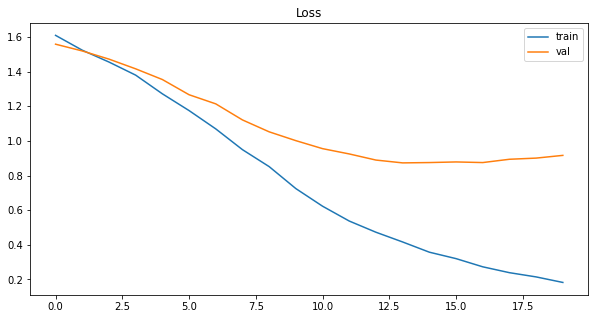

In [11]:
pd.DataFrame(losses_scores).plot(title='Loss',figsize=(10,5))

<AxesSubplot:title={'center':'Accuracy'}>

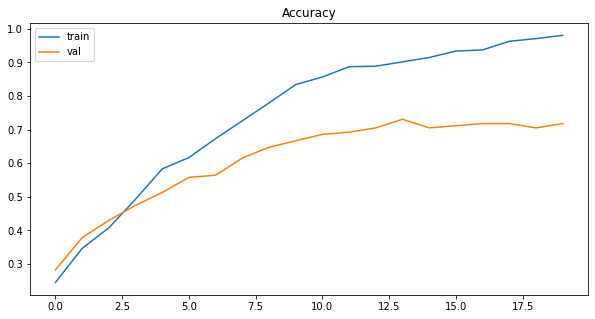

In [12]:
pd.DataFrame(accuracy_scores).plot(title='Accuracy',figsize=(10,5))

In [13]:
true_labels


[1,
 1,
 3,
 4,
 4,
 0,
 4,
 2,
 0,
 2,
 0,
 0,
 4,
 1,
 0,
 3,
 4,
 1,
 0,
 3,
 1,
 0,
 1,
 0,
 1,
 1,
 4,
 1,
 1,
 0,
 1,
 4,
 2,
 0,
 0,
 3,
 3,
 4,
 2,
 4,
 4,
 4,
 3,
 4,
 1,
 3,
 4,
 0,
 4,
 1,
 1,
 4,
 3,
 0,
 3,
 2,
 1,
 4,
 0,
 2,
 3,
 3,
 3,
 1,
 2,
 1,
 1,
 3,
 4,
 4,
 2,
 1,
 0,
 4,
 1,
 4,
 1,
 4,
 4,
 1,
 2,
 0,
 3,
 1,
 4,
 0,
 0,
 1,
 1,
 3,
 4,
 0,
 0,
 1,
 2,
 4,
 1,
 4,
 4,
 4,
 1,
 4,
 3,
 1,
 1,
 4,
 3,
 1,
 3,
 0,
 3,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 1,
 3,
 3,
 3,
 1,
 3,
 1,
 4,
 3,
 4,
 1,
 2,
 2,
 4,
 2,
 3,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 4,
 1,
 3,
 4,
 0,
 0,
 2,
 3,
 4,
 3,
 2,
 3,
 2,
 3,
 3]

In [14]:
false = [i for i in range(len(true_labels)) if true_labels[i]!=pred_labels[i]]
false

[4,
 5,
 9,
 13,
 14,
 15,
 16,
 26,
 32,
 36,
 38,
 43,
 48,
 52,
 56,
 64,
 70,
 72,
 73,
 83,
 85,
 92,
 94,
 97,
 102,
 111,
 113,
 115,
 116,
 117,
 120,
 125,
 126,
 127,
 129,
 130,
 132,
 144,
 147,
 148,
 152,
 153,
 154,
 155]

In [15]:
hate_df.iloc[val_idx[false]].to_csv(r'False.csv')